In [1]:
import torch
import tensorflow as tf
tf.config.get_visible_devices()

2024-04-28 15:34:14.287134: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 15:34:14.287175: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 15:34:14.287189: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-28 15:34:14.291351: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-28 15:34:15.367081: I tensorflow/compiler/

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

from datetime import datetime

now = datetime.now()

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline


from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
import lightgbm as lgb

import tensorflow as tf
import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten, dot
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

In [3]:
#!/usr/bin/env python
# coding: utf-8
"""
This is a example of MAG generation and data processing on the MovieLens dataset.
"""

import numpy as np
import csv
import pandas as pd
import random
import pickle
import copy
from scipy.sparse import csr_matrix

np.random.seed(2023)
random.seed(2023)

path = 'ratings.dat'
reviews_df  = pd.read_csv(path,sep='::',header=None)
reviews_df.columns = ['user_id','item_id','rating','timestamp']
# reviews_df.loc[:,'rating'] = reviews_df['rating'].map(lambda x: 1 if x >= 4 else 0)

# reindex of the IDs
def build_map(df, col_name):
    key = sorted(df[col_name].unique().tolist())
    m = dict(zip(key, range(1,len(key)+1)))
    df.loc[:,col_name] = df[col_name].map(lambda x: m[x])
    return m, key


uid_map, uid_key = build_map(reviews_df, 'user_id')


path = 'movies.dat'
meta_df  = pd.read_csv(path,sep='::',header=None)
meta_df.columns = ['item_id','title','genres']
meta_df = meta_df[['item_id', 'genres']]
meta_df.loc[:,'genres'] = meta_df['genres'].map(lambda x: x.split('|')[0])

vid_map, vid_key = build_map(meta_df, 'item_id')
cat_map, cat_key = build_map(meta_df, 'genres')

user_count, item_count, cate_count, example_count =    len(uid_map), len(vid_map), len(cat_map), reviews_df.shape[0]
print('user_count: %d\titem_count: %d\tcate_count: %d\texample_count: %d' %
      (user_count, item_count, cate_count, example_count))

meta_df = meta_df.sort_values('item_id')
meta_df = meta_df.reset_index(drop=True)

reviews_df['item_id'] = reviews_df['item_id'].map(lambda x: vid_map[x])
reviews_df = reviews_df.sort_values(['user_id', 'timestamp'])
reviews_df = reviews_df.reset_index(drop=True)

cate_list = [meta_df['genres'][i] for i in range(len(vid_map))]
cate_list = np.array(cate_list, dtype=np.int32)

cate_list = np.insert(cate_list, 0, 0)

with open('remap.pkl', 'wb') as f:
    pickle.dump(reviews_df, f, pickle.HIGHEST_PROTOCOL) # uid, iid, time(sorted)
    pickle.dump(cate_list, f, pickle.HIGHEST_PROTOCOL) # cid of iid line
    pickle.dump((user_count, item_count, cate_count, example_count),
              f, pickle.HIGHEST_PROTOCOL)
    pickle.dump((vid_key, cat_key, uid_key), f, pickle.HIGHEST_PROTOCOL)


/tmp/ipykernel_289350/379272165.py:19: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  reviews_df  = pd.read_csv(path,sep='::',header=None)
/tmp/ipykernel_289350/379272165.py:35: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  meta_df  = pd.read_csv(path,sep='::',header=None)


user_count: 69878	item_count: 10681	cate_count: 20	example_count: 10000054


In [4]:
reviews_df

,user_id,item_id,rating,timestamp
0,1,583,5.0,838983339
1,1,229,5.0,838983392
2,1,314,5.0,838983392
3,1,326,5.0,838983392
4,1,290,5.0,838983421
...,...,...,...,...
10000049,69878,1753,3.0,912649171
10000050,69878,258,5.0,912649271
10000051,69878,1662,4.0,912649271
10000052,69878,882,4.0,912649403


In [5]:

pos_cnt, neg_cnt = 0, 0
for userId, hist in reviews_df.groupby('user_id'):
    movie_list = hist['item_id'].tolist()
    label_list = hist['rating'].tolist()

    pos_cnt += sum(label_list)
    neg_cnt += len(label_list) - sum(label_list)
    
train_hist_time, test_time = list(np.quantile(reviews_df.timestamp, [0.80, 0.90]))
train_df = reviews_df[reviews_df.timestamp <= test_time]
test_df = reviews_df[reviews_df.timestamp > test_time]

if train_df.shape[0]+test_df.shape[0] == reviews_df.shape[0]:
    print("Split Correct!")
else:
    print("Split Error!")

Split Correct!


In [6]:
train_df

,user_id,item_id,rating,timestamp
0,1,583,5.0,838983339
1,1,229,5.0,838983392
2,1,314,5.0,838983392
3,1,326,5.0,838983392
4,1,290,5.0,838983421
...,...,...,...,...
10000049,69878,1753,3.0,912649171
10000050,69878,258,5.0,912649271
10000051,69878,1662,4.0,912649271
10000052,69878,882,4.0,912649403


In [7]:
test_df

,user_id,item_id,rating,timestamp
4425,32,5254,4.0,1208669626
4426,32,9707,2.0,1208669698
4427,32,3477,4.5,1208669735
4428,32,1662,3.0,1208669755
4429,32,641,3.0,1208669784
...,...,...,...,...
9999654,69873,2123,4.0,1216573669
9999655,69873,2097,4.0,1216573677
9999656,69873,2101,4.5,1216573680
9999657,69873,3283,5.0,1216575007


In [8]:
train_eval_df = reviews_df[(reviews_df.timestamp > train_hist_time) & (reviews_df.timestamp <= test_time)]

In [9]:
train_eval_df

,user_id,item_id,rating,timestamp
69,3,4443,4.0,1164885526
70,3,7042,3.5,1164885564
71,3,3323,4.0,1164885590
72,3,5204,3.0,1164885617
73,3,5432,4.5,1164885648
...,...,...,...,...
9999697,69874,4291,4.5,1162134523
9999698,69874,5890,4.0,1162134604
9999699,69874,2806,3.5,1162134613
9999700,69874,9119,3.5,1162134964


In [10]:
train_trai_df = reviews_df[reviews_df.timestamp < train_hist_time]

In [11]:
# train_matrix = train_df.pivot(index='user_id', columns='item_id', values='rating')
train_matrix = np.zeros((user_count+1, item_count+1))
for row in train_df.to_numpy():
    train_matrix[int(row[0]),int(row[1])]=row[2]

In [12]:
train_matrix.shape

(69879, 10682)

In [13]:
train_matrix[1,583]

5.0

In [14]:
test_matrix = np.zeros((user_count+1, item_count+1))
for row in test_df.to_numpy():
    test_matrix[int(row[0]),int(row[1])]=row[2]

baseline experiments

In [15]:
actual_test = test_matrix[test_matrix.nonzero()].flatten()

In [16]:
actual_test.size

1000006

In [17]:
actual_test

array([3. , 3. , 3. , ..., 4.5, 4.5, 1. ])

In [18]:
min(actual_test)

0.5

In [19]:
pred_test = np.zeros(actual_test.size)
pred_test[pred_test==0] = 3.5
pred_test

array([3.5, 3.5, 3.5, ..., 3.5, 3.5, 3.5])

In [20]:
pred_test.size

1000006

In [21]:
print("Mean  Squared Error is : ", mean_squared_error(pred_test, actual_test))

Mean  Squared Error is :  1.016053153681078


In [22]:
n_latent_factors = 1
user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=user_count, output_dim=n_latent_factors,name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)
movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=item_count,output_dim=n_latent_factors,name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)
product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

2024-04-28 15:35:07.298720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 15:35:07.298883: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 15:35:07.298950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 movie (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 movie_embedding (Embedding  (None, 1, 1)                 10681     ['movie[0][0]']               
 )                                                                                                
                                                                                                  
 user_embedding (Embedding)  (None, 1, 1)                 69878     ['user[0][0]']            

In [24]:
import torch

In [25]:
train_df

,user_id,item_id,rating,timestamp
0,1,583,5.0,838983339
1,1,229,5.0,838983392
2,1,314,5.0,838983392
3,1,326,5.0,838983392
4,1,290,5.0,838983421
...,...,...,...,...
10000049,69878,1753,3.0,912649171
10000050,69878,258,5.0,912649271
10000051,69878,1662,4.0,912649271
10000052,69878,882,4.0,912649403


In [26]:
train_eval_df

,user_id,item_id,rating,timestamp
69,3,4443,4.0,1164885526
70,3,7042,3.5,1164885564
71,3,3323,4.0,1164885590
72,3,5204,3.0,1164885617
73,3,5432,4.5,1164885648
...,...,...,...,...
9999697,69874,4291,4.5,1162134523
9999698,69874,5890,4.0,1162134604
9999699,69874,2806,3.5,1162134613
9999700,69874,9119,3.5,1162134964


In [27]:
train_trai_df

,user_id,item_id,rating,timestamp
0,1,583,5.0,838983339
1,1,229,5.0,838983392
2,1,314,5.0,838983392
3,1,326,5.0,838983392
4,1,290,5.0,838983421
...,...,...,...,...
10000049,69878,1753,3.0,912649171
10000050,69878,258,5.0,912649271
10000051,69878,1662,4.0,912649271
10000052,69878,882,4.0,912649403


In [28]:
train_df

,user_id,item_id,rating,timestamp
0,1,583,5.0,838983339
1,1,229,5.0,838983392
2,1,314,5.0,838983392
3,1,326,5.0,838983392
4,1,290,5.0,838983421
...,...,...,...,...
10000049,69878,1753,3.0,912649171
10000050,69878,258,5.0,912649271
10000051,69878,1662,4.0,912649271
10000052,69878,882,4.0,912649403


In [29]:
train_df.user_id.to_numpy()

array([    1,     1,     1, ..., 69878, 69878, 69878])

In [30]:
history = model.fit(x=[train_df.user_id, train_df.item_id],
                    y=train_df.rating, epochs=50, batch_size = 256,
                    validation_data=([train_eval_df.user_id,
                                      train_eval_df.item_id], train_eval_df.rating),
                    verbose=1)

Epoch 1/50
    1/35157 [..............................] - ETA: 8:59:01 - loss: 13.7367

2024-04-28 15:35:08.473037: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f28acd3b410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-28 15:35:08.473056: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-04-28 15:35:08.476879: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-28 15:35:08.485396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-04-28 15:35:08.558520: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35157/35157 [==============================] - 44s 1ms/step - loss: 4.1307 - val_loss: 1.1797
Epoch 2/50
35157/35157 [==============================] - 40s 1ms/step - loss: 0.9058 - val_loss: 0.8194
Epoch 3/50
35157/35157 [==============================] - 40s 1ms/step - loss: 0.8019 - val_loss: 0.7483
Epoch 4/50
35157/35157 [==============================] - 40s 1ms/step - loss: 0.7840 - val_loss: 0.7235
Epoch 5/50
35157/35157 [==============================] - 40s 1ms/step - loss: 0.7779 - val_loss: 0.7119
Epoch 6/50
35157/35157 [==============================] - 40s 1ms/step - loss: 0.7750 - val_loss: 0.7061
Epoch 7/50
35157/35157 [==============================] - 40s 1ms/step - loss: 0.7732 - val_loss: 0.7022
Epoch 8/50
35157/35157 [==============================] - 40s 1ms/step - loss: 0.7722 - val_loss: 0.7003
Epoch 9/50
35157/35157 [==============================] - 40s 1ms/step - loss: 0.7713 - val_loss: 0.6986
Epoch 10/50
35157/35157 [==============================] - 40s 1ms

In [31]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x=[test_df.user_id, test_df.item_id],
                    y=test_df.rating, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
# print("Generate predictions for 3 samples")
# predictions = model.predict(X_test[:3])
# print("predictions shape:", predictions.shape)

Evaluate on test data
7813/7813 [==============================] - 5s 681us/step - loss: 11.6564
test loss, test acc: 11.656394004821777


In [32]:
output = model.predict(x=[test_df.user_id, test_df.item_id])
output1 = np.array(output).flatten()

31251/31251 [==============================] - 17s 556us/step


In [33]:
for i in range(output.shape[0]):
    if output1[i]>=4:
        output1[i] = 1
    else:
        output1[i]=0

In [34]:
np.array(output1)
test_ratings = np.array(test_df.rating.copy())
print(test_ratings.shape)
for i in range(test_ratings.shape[0]):
    if test_ratings[i]>=4:
        test_ratings[i] = 1
    else:
        test_ratings[i]=0
test_ratings

(1000006,)


array([1., 0., 1., ..., 1., 1., 0.])

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score (test_ratings, output1)

0.5168418398041632

In [36]:
output1

array([0., 1., 0., ..., 0., 0., 0.], dtype=float32)

In [37]:
test_ratings

array([1., 0., 1., ..., 1., 1., 0.])

In [38]:
product.shape

TensorShape([None, 1])

Minimum loss:  0.6913028955459595


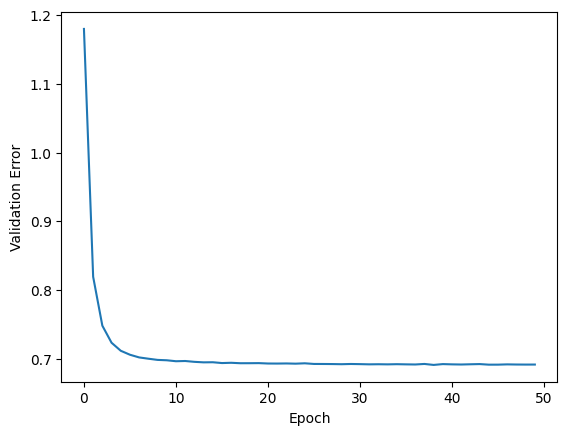

In [39]:
pd.Series(history.history['val_loss'][0:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum loss: ', min(history.history['val_loss']))

In [40]:
pip install pydot

/bin/bash: /opt/miniconda/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [41]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

FileNotFoundError: [Errno 2] "dot" not found in path.